In [1]:

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt


/home/maram/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("sst", "default") #load dataset 
#Familiarize with the dataset


In [3]:
#print first example of the training set
print(dataset['train'][:1])


{'sentence': ["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."], 'label': [0.6944400072097778], 'tokens': ["The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|."], 'tree': ['70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0']}


In [4]:
#splitting the dataset into training, val, and testing sets
train = {
    'sentence': dataset['train']['sentence'],
    'label': dataset['train']['label'],
}
val = {
    'sentence': dataset['validation']['sentence'],
    'label': dataset['validation']['label'],
}
test = {
    'sentence': dataset['test']['sentence'],
    'label': dataset['test']['label'],
}




In [5]:
for i in range(len(train['sentence'])):
    if train['label'][i] >= 0 and train['label'][i] <= 0.2:
        train['label'][i] = 0
    elif train['label'][i] > 0.2 and train['label'][i] <= 0.4:
        train['label'][i] = 1
    elif train['label'][i] > 0.4 and train['label'][i] <= 0.6:
        train['label'][i] = 2
    elif train['label'][i] > 0.6 and train['label'][i] <= 0.8:
        train['label'][i] = 3
    elif train['label'][i] > 0.8 and train['label'][i] <= 1:
        train['label'][i] = 4
  

In [6]:
for i in range(len(test['sentence'])):
    if test['label'][i] >= 0 and test['label'][i] <= 0.2:
        test['label'][i] = 0
    elif test['label'][i] > 0.2 and test['label'][i] <= 0.4:
        test['label'][i] = 1
    elif test['label'][i] > 0.4 and test['label'][i] <= 0.6:
        test['label'][i] = 2
    elif test['label'][i] > 0.6 and test['label'][i] <= 0.8:
        test['label'][i] = 3
    elif test['label'][i] > 0.8 and test['label'][i] <= 1:
        test['label'][i] = 4

### Part One : Naive Bayes

In [7]:
def naive_bayes_train(Document, classes):
    number_of_documents = len(Document['sentence'])
    big_document = {
        0 : {
            'sentence' : [],
            'tokens': []
        },
        1 : {
            'sentence' : [],
            'tokens': []
        },
        2 : {
            'sentence' : [],
            'tokens': []
        },
        3 : {
            'sentence' : [],
            'tokens': []
        },
        4 : {
            'sentence' : [],
            'tokens': []
        }

    }
    # Classify the documents into their respective classes
    vocab = set()
    for i in range(number_of_documents):
        class_index = Document['label'][i]
        big_document[class_index]['sentence'].append(Document['sentence'][i])
        tokens = Document['sentence'][i].split()
        big_document[class_index]['tokens'].append(tokens)
        for token in tokens:
            vocab.add(token)
    word_to_index = {
        word: i for i, word in enumerate(vocab)
    }

    # Log Priors
    log_priors = np.zeros(classes, dtype=np.float64)
    for i in range(classes):
        number_of_documents_in_class = len(big_document[i]['sentence'])
        log_priors[i] = np.log(number_of_documents_in_class / number_of_documents)
    
    print(f"Log Priors: {log_priors}")

    # Log Likelihood
    count_of_tokens = np.ones((len(vocab), classes), dtype=np.int64)
    for c in range(classes):
        for i in range(len(big_document[c]['sentence'])):
            for token in big_document[c]['tokens'][i]:
                index = word_to_index[token]
                count_of_tokens[index, c] += 1
    print(f"Count of Tokens: {count_of_tokens[word_to_index['the']]}")

    log_likelihood = np.zeros((len(vocab), classes), dtype=np.float64)
    for i in range(len(vocab)):
        for c in range(classes):
            log_likelihood[i, c] = np.log(count_of_tokens[i, c] / np.sum(count_of_tokens[:, c]))
    print(f"Log Likelihood: {log_likelihood[word_to_index['the']]}")
    return log_priors, log_likelihood, word_to_index

log_priors, log_likelihood, word_to_index = naive_bayes_train(train, 5)
        

Log Priors: [-2.0572184  -1.34862339 -1.66033704 -1.3028004  -1.89213865]
Count of Tokens: [ 762 1499 1106 1782  893]
Log Likelihood: [-3.94079155 -3.70303825 -3.77645389 -3.58261443 -3.86375454]


In [8]:
def naive_bayes_predict(sentence, log_priors, log_likelihood,classes, word_to_index):
    tokens = sentence.split()
    score = np.zeros(classes)
    for c in range(classes):
        score[c] = log_priors[c]
        for token in tokens:
            if token in word_to_index:
                score[c] += log_likelihood[word_to_index[token], c]
    return np.argmax(score)

print(naive_bayes_predict(test['sentence'][27], log_priors, log_likelihood, 5, word_to_index))
print(test['label'][27])

3
1


In [9]:
# Predicting the test dataset
def predict_test(test, log_priors, log_likelihood, classes, word_to_index):
    predictions = np.zeros(len(test['sentence']))
    for i in range(len(test['sentence'])):
        predictions[i] = naive_bayes_predict(test['sentence'][i], log_priors, log_likelihood, classes, word_to_index)
    return predictions

### Part Three : Confusion Matrix and Evaluation Metrics

In [10]:
def generate_confusion_matrix(predictions, labels, classes):
    confusion_matrix = np.zeros((classes, classes))

    for i in range(len(predictions)):
        #print(predictions[i], labels[i])
        confusion_matrix[int(predictions[i]), labels[i]] += 1
    return confusion_matrix

def precision(confusion_matrix, classes):
    precision = np.zeros(classes)
    for i in range(classes):

        precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])
    return precision

def recall(confusion_matrix, classes):
    recall = np.zeros(classes)
    for i in range(classes):
        recall[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
    return recall

def f1_score(precision, recall, classes):
    f1_score = np.zeros(classes)
    for i in range(classes):
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    return f1_score

def macro_f1(f1_score, classes):
    return np.sum(f1_score) / classes

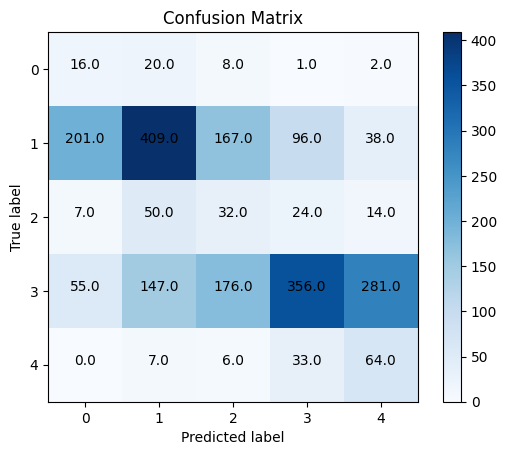

precision: [0.34042553 0.44895719 0.2519685  0.35073892 0.58181818]
recall: [0.05734767 0.64612954 0.08226221 0.69803922 0.160401  ]
f1_score: [0.09815951 0.52979275 0.12403101 0.46688525 0.25147348]
macro_f1: 0.2940683972753402


In [11]:
# Visualizing the confusion matrix
def plot_confusion_matrix(confusion_matrix, classes):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(classes)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            plt.text(j, i, str(confusion_matrix[i][j]), horizontalalignment="center", color="black")
    plt.show()

predictions = predict_test(test, log_priors, log_likelihood, 5, word_to_index)
confusion_matrix = generate_confusion_matrix(predictions, test['label'], 5)
plot_confusion_matrix(confusion_matrix, 5)
print(f"precision: {precision(confusion_matrix, 5)}")
print(f"recall: {recall(confusion_matrix, 5)}")

print(f"f1_score: {f1_score(precision(confusion_matrix, 5), recall(confusion_matrix, 5), 5)}")
print(f"macro_f1: {macro_f1(f1_score(precision(confusion_matrix, 5), recall(confusion_matrix, 5), 5), 5)}")

### Comparing Naive Bayes with Sci-kit Learn

In [12]:
def my_tokenizer(text):
    return text.split()

/home/maram/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


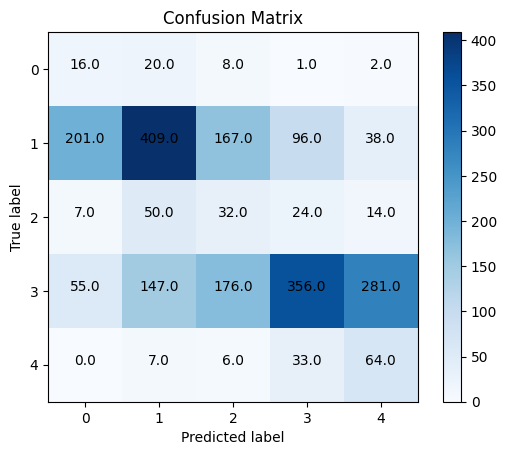

precision: [0.34042553 0.44895719 0.2519685  0.35073892 0.58181818]
recall: [0.05734767 0.64612954 0.08226221 0.69803922 0.160401  ]
f1_score: [0.09815951 0.52979275 0.12403101 0.46688525 0.25147348]
macro_f1: 0.2940683972753402


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix as cm
text_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=my_tokenizer, lowercase=False)),
    ('clf', MultinomialNB())
])
X_train = train['sentence']
y_train = train['label']
X_test = test['sentence']
y_test = test['label']
text_clf.fit(X_train, y_train)
predictions_sci = text_clf.predict(X_test)
confusion_matrix_sci=generate_confusion_matrix(predictions_sci, y_test, 5)
plot_confusion_matrix(confusion_matrix_sci, 5)
print(f"precision: {precision(confusion_matrix_sci, 5)}")
print(f"recall: {recall(confusion_matrix_sci, 5)}")
print(f"f1_score: {f1_score(precision(confusion_matrix_sci, 5), recall(confusion_matrix_sci, 5), 5)}")
print(f"macro_f1: {macro_f1(f1_score(precision(confusion_matrix_sci, 5), recall(confusion_matrix_sci, 5), 5), 5)}")


### using sklearn metrics

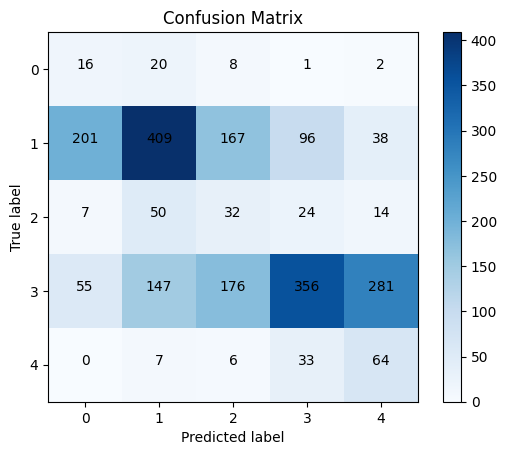

[0.34042553 0.44895719 0.2519685  0.35073892 0.58181818]
[0.05734767 0.64612954 0.08226221 0.69803922 0.160401  ]
[0.09815951 0.52979275 0.12403101 0.46688525 0.25147348]
0.2940683972753402


In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
plot_confusion_matrix(confusion_matrix(y_test, predictions_sci).transpose(),5)
print(precision_score(y_test, predictions_sci, average=None))
print(recall_score(y_test, predictions_sci, average=None))
print(f1_score(y_test, predictions_sci, average=None))
print(f1_score(y_test, predictions_sci, average='macro'))